#### Exercise 6 - Markov Chain Monte Carlo

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from collections import Counter
from scipy import stats

##### Problem 1
The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution:

$P(i) = c \cdot \frac{A^i}{i!},\ i = 0,...,m$

Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a χ2-test. You can use the parameter values from exercise 4.


In [254]:
g = lambda i: (8**i)/factorial(i) # Based on mean value of 8 from ex 4

def MH(n):
    
    X_i = np.zeros(n)
    X_i[0] = 0

    for i in range(n-1):

        current_state = X_i[i]
        proposed_state = np.random.randint(0, 11)
        

        acceptance_probability = min(1, g(proposed_state)/g(current_state))

        u = np.random.uniform()
        if u <= acceptance_probability:
            X_i[i+1] = proposed_state
        else:
            X_i[i+1] = current_state

    

    return X_i


def thin(sample, m):
    return [sample[i] for i in range(len(sample)) if i%3==0]


Simulating values, and finding probability distribution

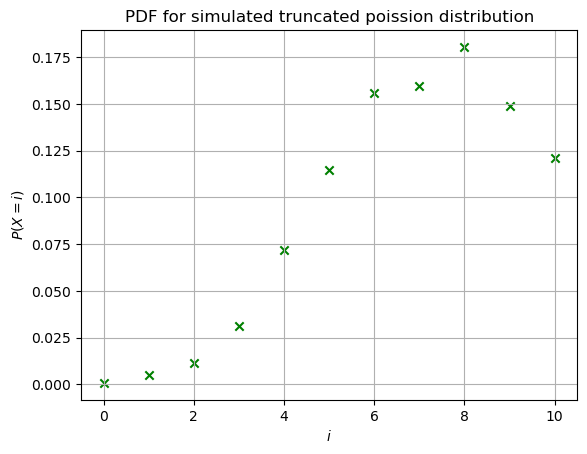

In [255]:
n = 10000

vals = MH(n)

def make_pdf(sample):
    
    n = len(vals)
    c = [(k, v) for k,v in Counter(vals).items()]
    c = sorted(c, key = lambda x: x[0])
    pdf = []
    indices = []
    
    for x in c:
        
        i, count = x[0], x[1]
        indices.append(i)
        pdf.append(count/n)

    return indices, pdf

indices, pdf = make_pdf(vals)
plt.scatter(indices,pdf, marker="x", color="g")
plt.grid()
plt.xlabel(r"$i$")
plt.title("PDF for simulated truncated poission distribution")
plt.ylabel(r"$P(X=i)$")
plt.show()

Verifying visually and with $\chi^2$:

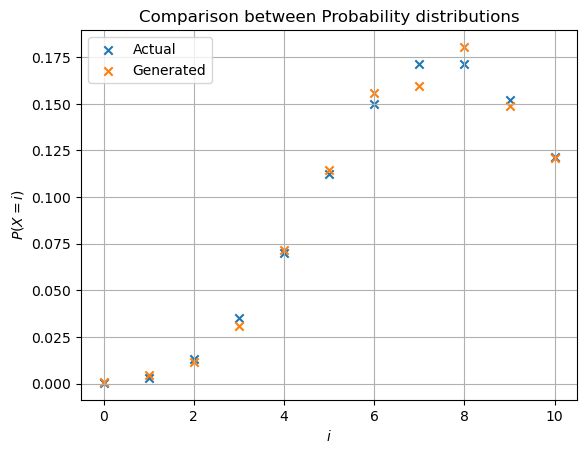

Test statistic: 31.63678884096877
P-value: 0.00046021814127081203
Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.


In [256]:
from scipy.stats import chisquare


def true_pdf(m, n):
    pdf = []
    for i in range(n+1):
        pdf.append((m**i)/factorial(i))
    return [i/sum(pdf) for i in pdf]

plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.scatter(indices,pdf, marker="x",label="Generated")
plt.grid()
plt.xlabel(r"$i$")
plt.title("Comparison between Probability distributions")
plt.legend(loc='upper left')
plt.ylabel(r"$P(X=i)$")
plt.show() 

# Proceeding with chi-2 test

chisq, p = chisquare(f_obs=[i*10000 for i in pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
if p < 0.05: print("Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.")
else: print("Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.")
    

Attempting to generate more acceptable sample, by thinning generated sample

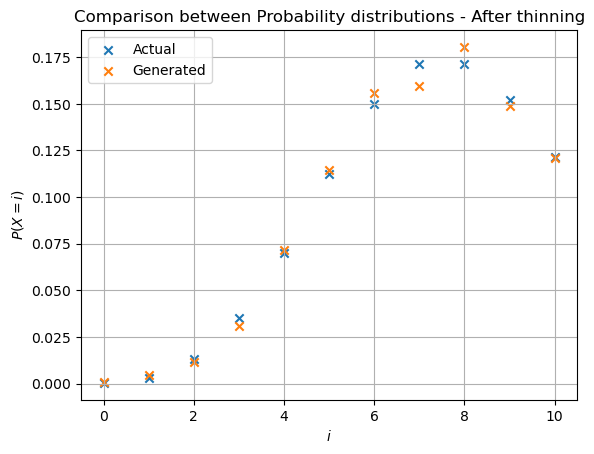

Test statistic: 10.547705399578996
P-value: 0.39382293709149313
Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.


In [259]:
thinned_sample = thin(vals, 5)

thinned_indices, thinned_pdf = make_pdf(thinned_sample)

plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.scatter(thinned_indices,thinned_pdf, marker="x",label="Generated")
plt.grid()
plt.xlabel(r"$i$")
plt.title("Comparison between Probability distributions - After thinning")
plt.legend(loc='upper left')
plt.ylabel(r"$P(X=i)$")
plt.show() 

chisq, p = chisquare(f_obs=[i*len(thinned_sample) for i in pdf], f_exp=[i*len(thinned_sample) for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
if p < 0.05: print("Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.")
else: print("Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.")

Null hypothesis is now accepted after thinning sample

Collecting multiple (1000) samples, conducting $\chi^2$ test, collecting p-values and seeing how many samples result in an accepted null hypothesis.

- For original, unthinned samples
- For samples with thinning parameter 3
- Samples with thinning parameter 5

In [268]:
p_vals_original, p_vals_3, p_vals_5 = [], [], []

def do_chi2(observed_sample):
    expected = [i*len(observed_sample) for i in true_pdf(8, 10)]
    _, pdf = make_pdf(observed_sample)
    observed = [i*len(observed_sample) for i in pdf]
    _, p = chisquare(f_obs=observed, f_exp=expected)
    return p



for i in range(100):
    n_original = 10000
    vals_original = MH(n)
    thinned_3 = thin(vals_original, 3)
    thinned_5 = thin(vals_original, 5)

    p, p_3, p_5 = do_chi2(vals_original), do_chi2(thinned_3), do_chi2(thinned_5)


    p_vals_original.append(p)
    p_vals_3.append(p_3)
    p_vals_5.append(p_5)

print(f"Percentage of original samples that pass chi-squared test: {100*round(len([i for i in p_vals_original if i > 0.05])/len(p_vals_original), 2)}%")
print(f"Percentage of samples (thinned with parameter 3) that pass chi-squared test: {100*round(len([i for i in p_vals_3 if i > 0.05])/len(p_vals_3), 2)}%")
print(f"Percentage of original samples (thinned with parameter 5) that pass chi-squared test: {100*round(len([i for i in p_vals_5 if i > 0.05])/len(p_vals_5), 2)}%")


Percentage of original samples that pass chi-squared test: 0.0%
Percentage of samples (thinned with parameter 3) that pass chi-squared test: 100.0%
Percentage of original samples (thinned with parameter 5) that pass chi-squared test: 100.0%


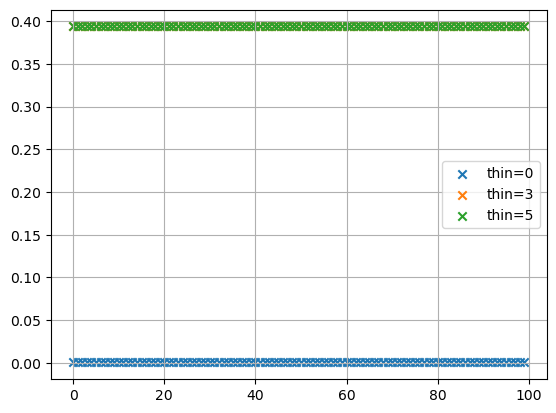

In [269]:
plt.scatter([i for i in range(len(p_vals_original))], p_vals_original, marker="x", label="thin=0")
plt.scatter([i for i in range(len(p_vals_3))], p_vals_3, marker="x", label="thin=3")
plt.scatter([i for i in range(len(p_vals_5))], p_vals_5, marker="x", label="thin=5")
plt.legend()
plt.grid()
plt.show()

As can be seen above, thinning the sample drastically increases its quality

---------------

##### Problem 2

For two different call types the joint number of occupied lines is given by:

$P(i,j) = c \cdot \frac{A^{i}_{1}}{i!} \frac{A^{j}_{2}}{j!}, \ 0 \leq i+j \leq m$

where $A_1, \ A_2 = 4 \text{ and } m = 10$


(a) Use Metropolis-Hastings, directly to generate variates from this distribution.

In [128]:
def MH2(n, A1=4, A2=4,m=10):

    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    
    X, Y = np.zeros(n), np.zeros(n)
    
    for l in range(n-1):

        current_X, current_Y = X[i], Y[i]

        proposed_X = np.random.randint(0, m+1)
        proposed_Y = np.random.randint(0, m-proposed_X+1)
        
        acceptance_probability = min(1, g(proposed_X, proposed_Y)/g(current_X, current_Y))

        u = np.random.uniform()
        if u <= acceptance_probability:
            
            X[i+1], Y[i+1] = proposed_X, proposed_Y
        
        else:
        
            X[i+1], Y[i+1] = current_X, current_Y

    
    return X, Y

Simulating sample

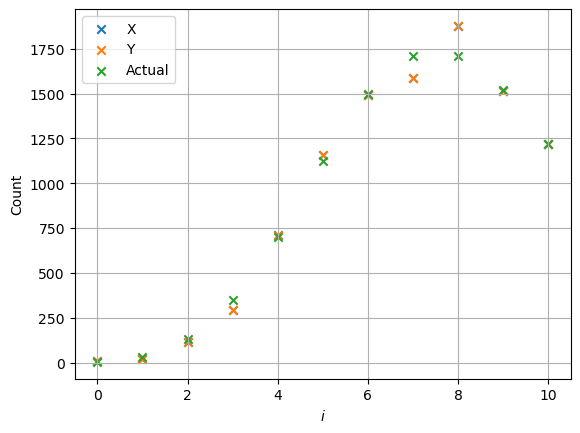

In [215]:
X1, Y1 = MH2(10000)

indices_X , X_pdf = make_pdf(X1)
indices_Y, Y_pdf = make_pdf(Y1)

plt.scatter(indices_X, [10000*i for i in X_pdf], marker="x", label="X")
plt.scatter(indices_Y, [i*10000 for i in Y_pdf], marker="x", label="Y")
plt.scatter([i for i in range(0, 11)],[10000*i for i in true_pdf(8, 10)], marker="x", label="Actual")
plt.ylabel("Count")
plt.grid()
plt.xlabel(r"$i$")
plt.legend(loc='upper left')
plt.show()

Conducting $\chi^2$ test

In [214]:
chisq, p = chisquare(f_obs=[i*10000 for i in X_pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test. \u03B1 = 0.05")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
if p < 0.05: print("Reject null hypothesis. Sufficient evidence to suggest samples do not come from the same distribution.")
else: print("Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.")

chi squared test. α = 0.05
Test statistic: 44.693151621743326
P-value: 2.4701566314851203e-06
Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.


Thinning sample and performing $\chi^2$ test

In [265]:
X1_thin_3 = thin(X1, 3)
p = do_chi2(X1_thin_3)
print(p)

0.39382293709149313


(b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.

Creating probability matrix

In [158]:
def create_probability_matrix(A1=4, A2=4, m=10):
    
    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    M = np.zeros(shape=(m+1, m+1))
    s = 0

    for i in range(m+1):
        for j in range(m+1):
            if i+j <=m:
                M[i][j] = g(i, j)
                s += g(i, j)

    return M/s

Coordinate-wise Metropolis-Hastings 

In [206]:
def MH_coord(n, A1=4, A2=4,m=10):

    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    
    X, Y = np.zeros(n), np.zeros(n)

    M = create_probability_matrix()
    
    # Initial coordinates

    X[0] = np.random.randint(0, m+1)
    Y[0] = np.random.randint(0, m+1)

    for l in range(n-1):

        current_X, current_Y = int(X[i]), int(Y[i])

        # Updating X coordinate
        
        x_probability = M[current_Y] / sum(M[current_Y]) # Probabilities of moving to a different x 
        new_X = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=x_probability)[0]

        # Updating Y coordinate

        y_probability = M[:,new_X] / sum(M[:,new_X])
        new_Y = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=y_probability)[0]
        
        acceptance_probability = min(1, g(new_X, new_Y)/g(current_X, current_Y))
        

        # Checking acceptance criteria

        u = np.random.uniform()
        if u <= acceptance_probability:
            
            X[i+1], Y[i+1] = new_X, new_Y
        
        else:
        
            X[i+1], Y[i+1] = current_X, current_Y
    
    return X, Y

Generating sample

In [207]:
X_c, Y_c = MH_coord(10000)


Verifying visually

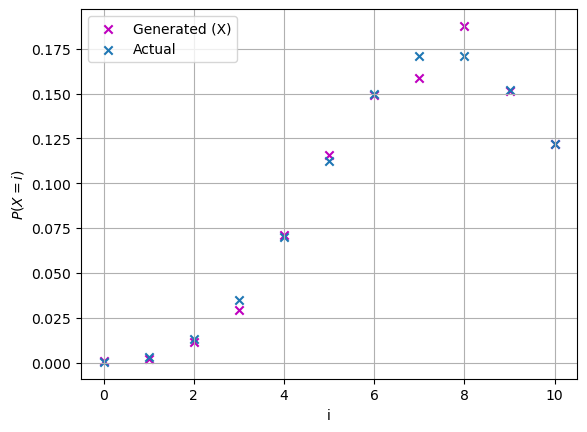

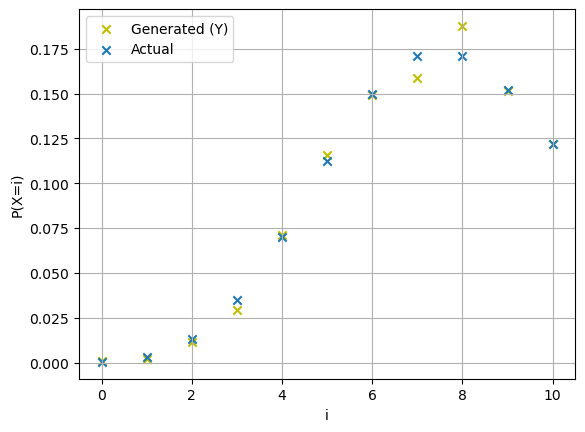

In [208]:
i_x, pdf_X_c = make_pdf(X_c)
i_Y, pdf_Y_c = make_pdf(Y_c)

plt.scatter(i_x, pdf_X_c, marker="x", color="m", label="Generated (X)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.ylabel(r"$P(X=i)$")
plt.xlabel(r"i")
plt.legend()
plt.grid()
plt.show()

plt.scatter(i_Y, pdf_Y_c, marker="x", color="y", label="Generated (Y)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.legend()
plt.grid()
plt.ylabel(r"P(X=i)")
plt.xlabel(r"i")
plt.legend()
plt.show()


Performing $\chi^2$ test

In [218]:
chisq, p = chisquare(f_obs=[i*10000 for i in pdf_X_c], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test. \u03B1 = 0.05")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
if p < 0.05: print("Reject null hypothesis. Sufficient evidence to suggest samples do not come from the same distribution.")
else: print("Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.")

chi squared test. α = 0.05
Test statistic: 44.693151621743326
P-value: 2.4701566314851203e-06
Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.


Collecting multiple samples, analysing p-values

(c) Use Gibbs sampling to sample from the distribution. This is (also) coordinate-wise but here we use the exact conditional distributions. You will need to find the conditional distributions analytically.

In [225]:
def gibbs(n, A1=4, A2=4, m=10):

    X, Y = np.zeros(n), np.zeros(n)

    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    M = create_probability_matrix()
    
    # Functions for calculating conditional probability

    px_given_y = lambda x, y: M[y][x]/sum(M[y])
    py_given_x = lambda x, y: M[y][x]/sum(M[:, x])
    
    # Randomly selecting start state
    
    X[0], Y[0] = np.random.randint(0, m+1), np.random.randint(0, m+1)

    for i in range(n-1):

        current_x, current_y = int(X[i]), int(Y[i])

        # Updating x 

        vals = [px_given_y(j, current_y) for j in range(m+1)]
        probabilities = [val/sum(vals) for val in vals] # Distribution of conditional probabilities P(X=i|current Y) 
        new_X = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=probabilities)[0]

        # Updating y

        vals = [py_given_x(new_X, j) for j in range(m+1)]
        probabilities = [val/sum(vals) for val in vals] # Distribution of conditional probabilities P(Y=j|new X)
        new_Y = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=probabilities)[0]

        # Inserting into samples
        X[i+1], Y[i+1] = new_X, new_Y
    
    return X, Y

Obtaining samples

In [226]:
X_gibbs, Y_gibbs = gibbs(10000)

Displaying distributions

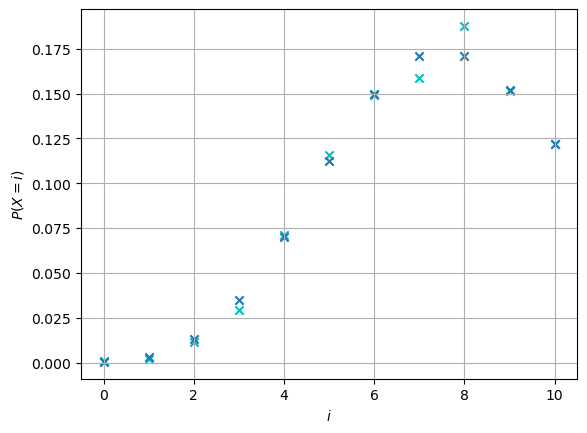

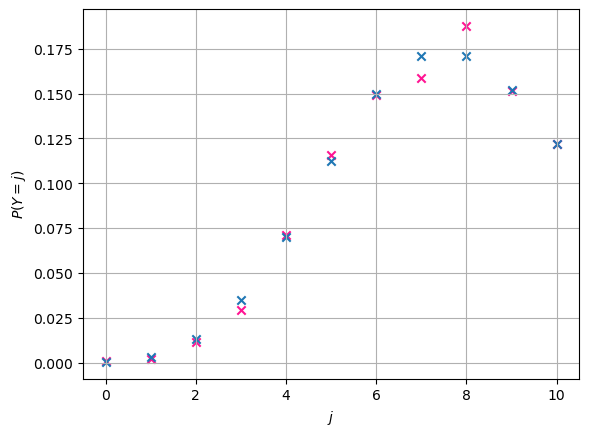

In [230]:
i_X_gibbs, X_gibbs_pdf = make_pdf(X_gibbs)
i_Y_gibbs, Y_gibbs_pdf = make_pdf(Y_gibbs)

plt.scatter(i_X_gibbs, X_gibbs_pdf, marker="x", color="c", label="Gibbs (X)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.grid()
plt.ylabel(r"$P(X=i)$")
plt.xlabel(r"$i$")
plt.show()
plt.scatter(i_Y_gibbs, Y_gibbs_pdf, marker="x", color="deeppink", label="Gibbs (Y)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.grid()
plt.ylabel(r"$P(Y=j)$")
plt.xlabel(r"$j$")
plt.show()

Performing $\chi^2$ test

In [231]:
chisq, p = chisquare(f_obs=[i*10000 for i in X_gibbs_pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test. \u03B1 = 0.05")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
if p < 0.05: print("Reject null hypothesis. Sufficient evidence to suggest samples do not come from the same distribution.")
else: print("Accept null hypothesis. Sufficient evidence to suggest that samples come from the same distribution.")

chi squared test. α = 0.05
Test statistic: 44.693151621743326
P-value: 2.4701566314851203e-06
Reject null hypothesis. Sufficient evidence to suggest samples come from different distributions.


-----------

##### Problem 3

 We consider a Bayesian statistical problem. The observations are $X_i \sim N(\Theta, \Psi)$, where the prior distribution of the pair $(\Xi, \Gamma) = (\log{\Theta}, \log{\Psi})$ is standard normal with correlation $\rho = \frac{1}{2}$.

 The joint density, $f(x, y)$ of $(\Theta, \Psi)$ is:

 $f(x,y) = \frac{1}{2 \pi x y \sqrt{1-\rho^2}} \exp{-\frac{\log{x}^2 - 2 \rho \log{x} \log{y} + \log{y}^2}{2 (1-\rho)^2}}$

which can be derived using a standard change of variable technique. The task of this exercise is now to sample from the posterior distribution of $(\Theta, \Psi)$ using Markov Chain Monte Carlo.

(a) Generate a pair $(\Theta, \Psi)$ from the prior distribution, i.e. the distribution for the pair $(\Theta, \Psi)$, by first generating a sample $(\xi, \gamma)$ of $(\Xi, \Gamma)$.

In [251]:
def sample_theta_psi(n, rho=1/2):
    
    z1 = np.random.normal(0, 1, size=n)    
    z2 = np.random.normal(0,1, size=n)
    xi = z1
    gamma = rho*z1 + np.sqrt(1-rho**2)*z2

    return np.exp(xi), np.exp(gamma)

# Example pair

sample_theta_psi(1)

(array([0.23743872]), array([1.21400596]))

(b) Generate Xi = 1, . . . , n with the values of (θ, ψ) you obtained in item 3a. Use n = 10.

In [237]:
X_i = [sample_theta_psi(1000) for i in range(10)]

(c) Derive the posterior distribution of (Θ, Ψ) given the sample